In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
from scipy.stats import wilcoxon
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge, measure_pce
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle

from ICOMP import *
# https://github.com/Pongpisit-Thanasutives/ICOMP
import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *
from mdl_comp import *

Sklearn's version: 1.4.0


#### Load data

In [2]:
data = sio.loadmat('../../PDE-FIND/Datasets/reaction_diffusion_2d_big.mat')
u_sol = (data['u']).real
v_sol = (data['v']).real
x = (data['x'][0]).real
y = (data['y'][0]).real
t = (data['t'][:,0]).real

n = 512; issub = 2
if issub > 1:
    spatial_sub_indices = np.array([i for i in range(n) if i%issub==0])
    u_sol = u_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    v_sol = v_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    x = x[spatial_sub_indices]
    y = y[spatial_sub_indices]
m = 201; issub = 1
if issub > 1:
    time_sub_indices = np.array([i for i in range(m) if i%issub==0])
    u_sol = u_sol[:, :, time_sub_indices]
    v_sol = v_sol[:, :, time_sub_indices]
    t = t[time_sub_indices]

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

# Ground truth
ground_indices_u = np.array((0, 2, 3, 4, 5, 8, 14))
ground_coeff_u = np.array([1.000,-1.000,1.000,-1.000,1.000,0.100,0.100])
ground_indices_v = np.array((1, 2, 3, 4, 5, 9, 15))
ground_coeff_v = np.array([1.000,-1.000,-1.000,-1.000,-1.000,0.100,0.100])

In [3]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

#### Add noise

In [4]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=False,
    include_interaction=True, 
    cache=True
)

u_noisy = u.copy()

### Add noise ###
noise_lv = 10
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(*u_noisy.shape)
u_noisy = u_noisy + domain_noise

#### Denoise

In [5]:
denoise = True
if denoise:
    un = u_noisy[:, :, :, 0].T
    vn = u_noisy[:, :, :, 1].T

    div = 30
    ws = max(un[0].shape)//div; po = 2
    if ws%2 == 0: ws -=1

    und = []
    for i in trange(un.shape[0]):
        und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
    und = np.stack(und, axis=0).T

    vnd = []
    for i in trange(vn.shape[0]):
        vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
    vnd = np.stack(vnd, axis=0).T

    u_noisy = np.stack((und, vnd), axis=-1)
    del und, vnd, un, vn

100%|███████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:01<00:00, 108.72it/s]


#### Applying best-subset regression on the weak formulation

In [6]:
# thres = 1e-4 # 1e-3
# # optimizer = ps.STLSQ(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# optimizer = ps.SR3(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# # optimizer = ps.MIOSR(target_sparsity=2*7, fit_intercept=False, normalize_columns=True)

# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
#                  cache=True, feature_names=['u', 'v'])
# model.fit(u_noisy, ensemble=False, library_ensemble=True)
# # model.print()
# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot

In [7]:
X_pre = np.load("./X_weak_RD.npy")
y_pre = np.load("./y_weak_RD.npy")
feature_names = np.load("feature_names_RD.npy", allow_pickle=True)

In [8]:
# feature_names = np.array(model.get_feature_names())
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre

In [9]:
solve_grb = solvel0(X_pre, u_pre, intercept=False, refine=True, max_complexity=10)

potential_indices = Counter(solve_grb[0])
for e in solve_grb[1:]: 
    potential_indices += Counter(e)
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:15]
potential_indices = sorted(potential_indices)
potential_feature_names = feature_names[potential_indices]

brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], u_pre, max_support_size=10)
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))
best_subsets_u = [tuple([map2pysindy[ei] for ei in effective_indices]) 
                  for effective_indices in brute_solve[-1]]
best_subsets_u

  0%|                                                                                                       | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.28it/s]


[(1,),
 (1, 14),
 (0, 1, 14),
 (0, 1, 8, 14),
 (0, 1, 8, 9, 14),
 (0, 1, 2, 4, 8, 14),
 (0, 2, 3, 4, 5, 8, 14),
 (0, 1, 2, 3, 4, 5, 8, 14),
 (0, 1, 2, 3, 4, 5, 8, 14, 39),
 (0, 1, 2, 3, 4, 5, 8, 14, 39, 42)]

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75
scale = np.log(len(u_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_u])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], u_pre))-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 8)
if last_lam == 0: last_lam = abs(last_lam)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

-14962.70186852511
0.028408923577772496
0 <---> 0 inf
0 <---> 6 0.030003039304471672
6 <---> 7 0.0020825485789059523


(1.31650405,
 array([-81804.19826203, -82158.80397844, -82167.78018335, -83993.69426712,
        -83736.88791037, -81586.79224411, -94598.81047957, -91355.3749831 ,
        -91223.14358921, -91094.15276425]),
 6)

In [11]:
solve_grb = solvel0(X_pre, v_pre, intercept=False, refine=True, max_complexity=10)

potential_indices = Counter(solve_grb[0])
for e in solve_grb[1:]: 
    potential_indices += Counter(e)
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:15]
potential_indices = sorted(potential_indices)
potential_feature_names = feature_names[potential_indices]

brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], v_pre, max_support_size=10)
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))
best_subsets_v = [tuple([map2pysindy[ei] for ei in effective_indices]) 
                  for effective_indices in brute_solve[-1]]
best_subsets_v

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


[(0,),
 (0, 15),
 (0, 1, 15),
 (0, 1, 9, 15),
 (0, 1, 8, 9, 15),
 (0, 1, 3, 5, 9, 15),
 (1, 2, 3, 4, 5, 9, 15),
 (0, 1, 2, 3, 4, 5, 9, 15),
 (0, 1, 2, 3, 4, 5, 9, 15, 64),
 (0, 1, 2, 3, 4, 5, 9, 15, 39, 64)]

In [12]:
tau = 3; per = 75
scale = np.log(len(v_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_v])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], v_pre))-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 8)
if last_lam == 0: last_lam = abs(last_lam)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

-15915.512397809725
0.031631936733893584
0 <---> 0 inf
0 <---> 6 0.03242979226035913
6 <---> 6 inf


(0.0,
 array([-81057.31443102, -81634.81591469, -82065.30731763, -84914.07706098,
        -85012.99421079, -87174.03385972, -96742.3344358 , -96730.6083764 ,
        -96723.92957382, -96716.0817433 ]),
 6)

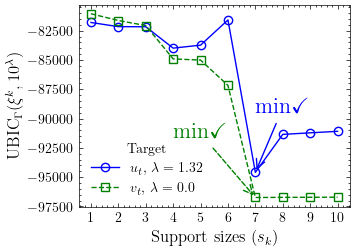

In [13]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(complexities, last_ubic_d_u, 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda =$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities, last_ubic_d_v, 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda =$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]+5000), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities[last_bc_d_v]-3, last_ubic_d_v[last_bc_d_v]+5000), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    plt.legend(fontsize=10, title='Target')
    # plt.savefig("../Figures2/rd2d_ubics.pdf")
    plt.show()

#### Percent coefficient error

In [14]:
assert np.alltrue(best_subsets_v[last_bc_d_v] == ground_indices_v) and np.alltrue(best_subsets_u[last_bc_d_u] == ground_indices_u)
errs_u = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_u], u_pre, rcond=None)[0].flatten(), 
                     ground_coeff_u)
errs_v = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_v], v_pre, rcond=None)[0].flatten(), 
                     ground_coeff_v)
print(errs_u.mean(), errs_u.std())
print(errs_v.mean(), errs_v.std())

2.1639872194525807 1.4818550985129506
2.2967262127974317 1.6589786810247757


In [15]:
theta_u, dt_u = shuffle(X_pre, u_pre, random_state=0)
theta_v, dt_v = shuffle(X_pre, v_pre, random_state=0)

In [16]:
n_resample = 30
n_samples = len(dt_u)//n_resample
v_icomps = []
for bs in best_subsets_u:
    icomps = []
    beta = np.linalg.lstsq(theta_u[:, bs], dt_u, rcond=None)[0]
    for _ in range(n_resample):
        idx = sample_without_replacement(n_population=theta_u.shape[0]-1, n_samples=n_samples, random_state=_)
        X_resample, y_resample = theta_u[idx], dt_u[idx]
        X_resample = X_resample[:, bs]
        llf, CM, icomp = llf_complexity(X_resample, y_resample, beta=beta, a_n=np.log(len(y_resample)))
        icomp = icomp[2]
        icomps.append(icomp)
    v_icomps.append(icomps)
v_icomps = np.array(v_icomps)
v_icomps_ranking = np.argsort(v_icomps.sum(axis=-1))

oks = [0]
for i in range(1, len(best_subsets_u)):
    wres = wilcoxon(v_icomps[i], v_icomps[i-1], alternative='less')
    print(wres.pvalue)
    if wres.pvalue < 1e-2: 
        oks.append(i)
oks

4.6566128730773926e-09
0.19652509037405252
6.51925802230835e-08
0.013870718888938427
0.9999999981373549
9.313225746154785e-10
1.0
1.0
1.0


[0, 1, 3, 6]

Threshold 0.029973284473186982
P-Threshold 0.01
4810026249.943338 6 0
210480.35290762494 6 0
7417.079525361611 6 0
1392.3346192251677 6 0
510.32874739055575 6 3
261.3691393309394 6 6
num_an: 6
6 ---> 3 0.04431163868032737 1.0 9.313225746154785e-10
9.210340371976184 [-81971.37960931 -82589.52012546 -82949.37111289 -85139.72719248
 -85261.41500351 -87918.36527522 -96457.76967856] 6


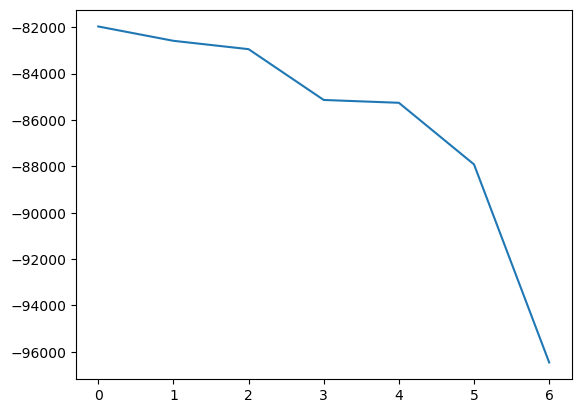

In [18]:
a_n = np.log(len(dt_u))
CMs = []; llfs = []
# for bs in best_subsets_u: 
for bs in best_subsets_u[:oks[-1]+1]: 
    beta = np.linalg.lstsq(theta_u[:, bs], dt_u, rcond=None)[0]
    llf, CM, _ = llf_complexity(theta_u[:, bs], dt_u, beta=beta, a_n=a_n)
    CM = CM[2]
    if np.equal(CM, np.inf): break
    CMs.append(CM)
    llfs.append(llf)
llfs = np.array(llfs); CMs = np.array(CMs)
last_icomps, last_bc = icomp_ic(llfs, CMs, a_n)
icomps = last_icomps.copy()
per = 75
d_complexities = np.array(complexities)[decreasing_values_indices(icomps)]
d_icomps = icomps[decreasing_values_indices(icomps)]
thres = np.percentile(np.abs(np.diff(d_icomps)/(np.diff(d_complexities)*d_icomps[:-1])), per)
print("Threshold", thres)
pthres = 1e-2
print("P-Threshold", pthres)

num_an = 2
for num_an in range(2, 11):
    a_ns = np.log(len(dt_u))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
    a_n = a_ns[1]
    last_bc = icomp_ic(llfs, CMs, a_ns[0])[1]
    now_bc = icomp_ic(llfs, CMs, a_n)[1]
    print(a_n, last_bc, now_bc)
    if last_bc == now_bc:
        num_an = num_an-1
        num_an = max(num_an, 2)
        break
a_ns = np.log(len(dt_u))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
last_an = a_ns[0]
print("num_an:",  num_an)

for a_n in a_ns[1:]:
    now_icomp, now_bc = icomp_ic(llfs, CMs, a_n)
    
    diff_com = now_bc-last_bc
    diff_icomp = icomps[now_bc]-icomps[last_bc]
    imp = abs(diff_icomp/(icomps[min(last_bc, now_bc)]*diff_com))
    diff_v_icomp = v_icomps[now_bc]-v_icomps[last_bc]
    pvalue_pos, pvalue_neg, pvalue_adj = np.nan, np.nan, np.nan
    adj_now_coms = v_icomps_ranking[v_icomps_ranking<now_bc]
    if not np.array_equal(diff_v_icomp, np.zeros(len(diff_v_icomp))):
        pvalue_pos = wilcoxon(diff_v_icomp, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_v_icomp, alternative='less').pvalue
        if len(adj_now_coms) != 0:
            pvalue_adj = wilcoxon(v_icomps[now_bc]-v_icomps[adj_now_coms[0]], alternative='less').pvalue
            
    print(last_bc, '--->', now_bc, 
          np.nan_to_num(imp, nan=np.inf), 
          np.nan_to_num(pvalue_pos, nan=np.inf), 
          np.nan_to_num(pvalue_neg, nan=np.inf))
    
    ### Old version ###
    # if (diff_com > 0 and (diff_icomp > 0 or imp <= thres)) or \
    #     (diff_com < 0 and diff_icomp > 0 and imp >= thres):
    #     break
    
    if (diff_com > 0 and (diff_icomp > 0 or pvalue_pos > pthres or pvalue_adj > pthres)) or \
        (diff_com < 0 and diff_icomp > 0 and pvalue_neg <= pthres):
        break
    
    last_an = a_n
    last_icomps = now_icomp
    last_bc = now_bc
    
print(last_an, last_icomps, last_bc)
last_icomps_u = last_icomps
plt.plot(last_icomps); plt.show()

6


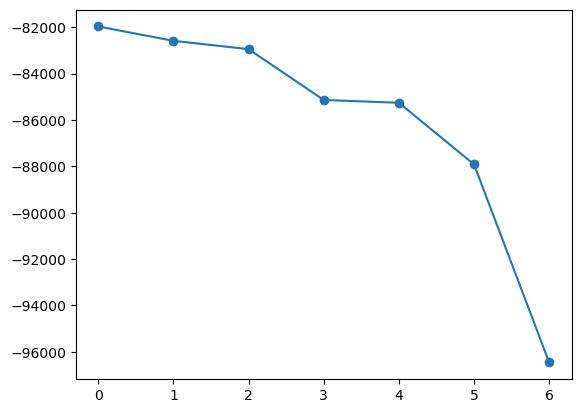

In [19]:
mdls = []
for bs in best_subsets_u[:oks[-1]+1]: 
    X_train = theta_u[:, bs]
    beta = np.linalg.lstsq(X_train, dt_u, rcond=None)[0]
    var = np.linalg.norm(dt_u-X_train@beta, ord=2)**2
    var = var/(len(dt_u)-len(bs))
    prac_mdl = prac_mdl_comp(X_train, dt_u, variance=var)
    mdl = prac_mdl['prac_mdl']
    thetahat = prac_mdl['thetahat']
    
    llf, CM, icomp = llf_complexity(X_train, dt_u, 
                                    beta=thetahat, 
                                    a_n=last_an)
    icomp = icomp[2]
    
    # mdls.append(mdl)
    mdls.append(icomp)

print(np.argmin(mdls))
plt.plot(mdls, '-o'); plt.show()

In [20]:
n_resample = 30
n_samples = len(dt_v)//n_resample
v_icomps = []
for bs in best_subsets_v:
    icomps = []
    beta = np.linalg.lstsq(theta_v[:, bs], dt_v, rcond=None)[0]
    for _ in range(n_resample):
        idx = sample_without_replacement(n_population=theta_u.shape[0]-1, n_samples=n_samples, random_state=_)
        X_resample, y_resample = theta_v[idx], dt_v[idx]
        X_resample = X_resample[:, bs]
        llf, CM, icomp = llf_complexity(X_resample, y_resample, beta=beta, a_n=np.log(len(y_resample)))
        icomp = icomp[2]
        icomps.append(icomp)
    v_icomps.append(icomps)
v_icomps = np.array(v_icomps)
v_icomps_ranking = np.argsort(v_icomps.sum(axis=-1))

oks = [0]
for i in range(1, len(best_subsets_u)):
    wres = wilcoxon(v_icomps[i], v_icomps[i-1], alternative='less')
    print(wres.pvalue)
    if wres.pvalue < 1e-2: 
        oks.append(i)
oks

2.3283064365386963e-08
0.00030420441180467606
9.313225746154785e-10
0.47576323710381985
0.9999999972060323
9.313225746154785e-10
1.0
1.0
1.0


[0, 1, 2, 3, 6]

Threshold 0.032448309677437365
P-Threshold 0.01
4989707864.019504 6 0
214375.62311127142 6 0
7508.309386848274 6 0
1405.1592280981163 6 0
514.0857525200437 6 3
262.97164309289394 6 6
num_an: 6
6 ---> 3 0.04557883456148561 1.0 9.313225746154785e-10
9.210340371976184 [-81043.72352057 -81635.40677175 -82076.13413385 -84930.97579587
 -85053.23158968 -87217.38521343 -96544.14048071] 6


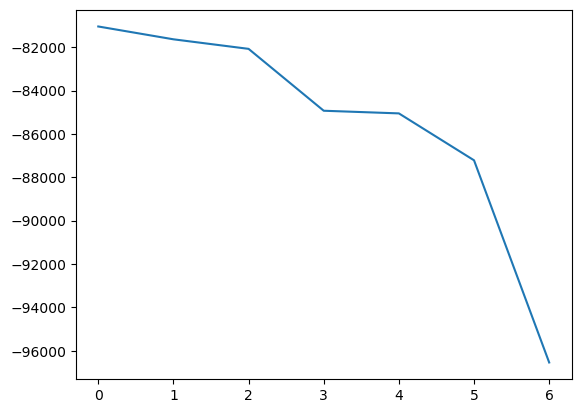

In [21]:
a_n = np.log(len(dt_v))
CMs = []; llfs = []
# for bs in best_subsets_u: 
for bs in best_subsets_v[:oks[-1]+1]: 
    beta = np.linalg.lstsq(theta_v[:, bs], dt_v, rcond=None)[0]
    llf, CM, _ = llf_complexity(theta_v[:, bs], dt_v, beta=beta, a_n=a_n)
    CM = CM[2]
    if np.equal(CM, np.inf): break
    CMs.append(CM)
    llfs.append(llf)
llfs = np.array(llfs); CMs = np.array(CMs)
last_icomps, last_bc = icomp_ic(llfs, CMs, a_n)
icomps = last_icomps.copy()
per = 75
d_complexities = np.array(complexities)[decreasing_values_indices(icomps)]
d_icomps = icomps[decreasing_values_indices(icomps)]
thres = np.percentile(np.abs(np.diff(d_icomps)/(np.diff(d_complexities)*d_icomps[:-1])), per)
print("Threshold", thres)
pthres = 1e-2
print("P-Threshold", pthres)

num_an = 2
for num_an in range(2, 11):
    a_ns = np.log(len(dt_v))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
    a_n = a_ns[1]
    last_bc = icomp_ic(llfs, CMs, a_ns[0])[1]
    now_bc = icomp_ic(llfs, CMs, a_n)[1]
    print(a_n, last_bc, now_bc)
    if last_bc == now_bc:
        num_an = num_an-1
        num_an = max(num_an, 2)
        break
a_ns = np.log(len(dt_v))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
last_an = a_ns[0]
print("num_an:",  num_an)

for a_n in a_ns[1:]:
    now_icomp, now_bc = icomp_ic(llfs, CMs, a_n)
    
    diff_com = now_bc-last_bc
    diff_icomp = icomps[now_bc]-icomps[last_bc]
    imp = abs(diff_icomp/(icomps[min(last_bc, now_bc)]*diff_com))
    diff_v_icomp = v_icomps[now_bc]-v_icomps[last_bc]
    pvalue_pos, pvalue_neg, pvalue_adj = np.nan, np.nan, np.nan
    adj_now_coms = v_icomps_ranking[v_icomps_ranking<now_bc]
    if not np.array_equal(diff_v_icomp, np.zeros(len(diff_v_icomp))):
        pvalue_pos = wilcoxon(diff_v_icomp, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_v_icomp, alternative='less').pvalue
        if len(adj_now_coms) != 0:
            pvalue_adj = wilcoxon(v_icomps[now_bc]-v_icomps[adj_now_coms[0]], alternative='less').pvalue
            
    print(last_bc, '--->', now_bc, 
          np.nan_to_num(imp, nan=np.inf), 
          np.nan_to_num(pvalue_pos, nan=np.inf), 
          np.nan_to_num(pvalue_neg, nan=np.inf))
    
    ### Old version ###
    # if (diff_com > 0 and (diff_icomp > 0 or imp <= thres)) or \
    #     (diff_com < 0 and diff_icomp > 0 and imp >= thres):
    #     break
    
    if (diff_com > 0 and (diff_icomp > 0 or pvalue_pos > pthres or pvalue_adj > pthres)) or \
        (diff_com < 0 and diff_icomp > 0 and pvalue_neg <= pthres):
        break
    
    last_an = a_n
    last_icomps = now_icomp
    last_bc = now_bc
    
print(last_an, last_icomps, last_bc)
last_icomps_v = last_icomps
plt.plot(last_icomps); plt.show()

6


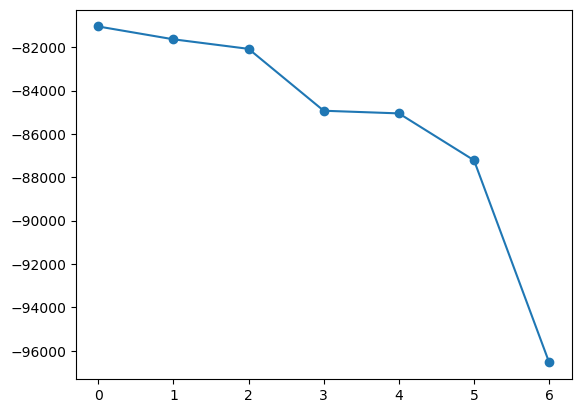

In [22]:
mdls = []
for bs in best_subsets_v[:oks[-1]+1]: 
    X_train = theta_v[:, bs]
    beta = np.linalg.lstsq(X_train, dt_v, rcond=None)[0]
    var = np.linalg.norm(dt_v-X_train@beta, ord=2)**2
    var = var/(len(dt_u)-len(bs))
    prac_mdl = prac_mdl_comp(X_train, dt_v, variance=var)
    mdl = prac_mdl['prac_mdl']
    thetahat = prac_mdl['thetahat']
    
    llf, CM, icomp = llf_complexity(X_train, dt_v, 
                                    beta=thetahat, 
                                    a_n=last_an)
    icomp = icomp[2]
    
    # mdls.append(mdl)
    mdls.append(icomp)

print(np.argmin(mdls))
plt.plot(mdls, '-o'); plt.show()

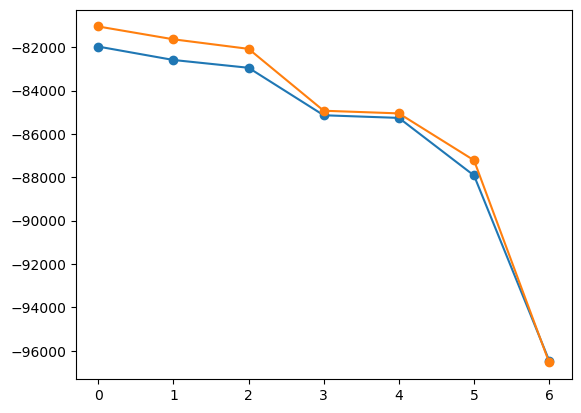

In [23]:
plt.plot(last_icomps_u, '-o')
plt.plot(last_icomps_v, '-o')